In [17]:
# %alias nbconvert nbconvert ./Block.ipynb

In [18]:
# %nbconvert

[NbConvertApp] Converting notebook ./Block.ipynb to python


In [201]:
import logging
import textwrap
from random import randrange
from PIL import Image, ImageDraw, ImageFont, ImageOps
from pathlib import Path

try:
    from . import constants
except ImportError as e:
    import constants

In [202]:
logger = logging.getLogger(__name__)
logger.root.setLevel('DEBUG')

In [203]:
def check_num(func):
    """decorator function wrapper"""
    def func_wrapper(self, d, *args, **kwargs):
        """Check for positive integers
        Params:
            d(int): integer to check
        
        Raises:
            ValueError - values that are negative, not integer"""
        if not isinstance(d, int):
            raise ValueError (f'{d} is not an integer')
        if d < 0:
            raise ValueError (f'{d} < 0 {func} only accepts values >= 0')
        return func(self, d, *args, **kwargs)
    return func_wrapper

In [204]:
def strict_enforce(*types):
    """strictly enforce type compliance within classes
    
    Usage:
    @strict_enforce(type1, type2, (type3, type4))
    def foo(val1, val2, val4):
        ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                if not isinstance(a, t):
                    raise TypeError(f'"{a}" is not type {t}')
#                 newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *args, **kwds)
        return new_f
    return decorator

In [206]:
def permissive_enforce(*types):
    """decorator to enforce type compliance within classes
    
    Allows similar types:
        for int: 0, 0.1
        for bool: 0, 1, 'some string', False, True
        for string: 7, 66, '77', 'some string', False, True
    
    Usage:
    @permissive_enforce(type1, type2, typeN)
    def foo(self, val1, val2, valN):
        ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *newargs, **kwds)
        return new_f
    return decorator

In [1223]:
class BlockError(Exception):
    pass
    

In [8]:
class xBlock:
    
    def __init__(self, area, hcenter=False, vcenter=False, rand=False, inverse=False,
                abs_coordinates=(0, 0), padding=0):
        """initialize the Block object
        
        Args:
            area (:obj:`tuple` of :obj:`int`): x, y integer dimensions of 
                maximum area in pixles
            hcenter (boolean, optional): True - horizontal-align image within the area, 
                False - left-align image                
            vcenter (boolean, optional): True - vertical-align image within the area,
                False - top-align image        
            rand (boolean, optional): True - ignore vcenter, hcenter choose random position for
                image within area
            padding(int) number of pixles to pad around edge of block
            abs_coordinates (:obj:`tuple` of `int`, optional): x, y integer coordinates of image area
                within a larger image 
            inverse (boolean, optional): True - invert black and white from default of black text
            on white background
            
        Properties:
            fill (int): fill color integer of 0 (black) or 255 (white)
            bkground (int): bkground integer of 0 (black) or 255 (white)
            img_coordinates(:obj:`tuple` of :obj:`int`): coordinates of image within the block 
                (legacy, no longer used)
            image (None): None in base class 
            dimensions (:obj:`tuple` of :obj:`int`): dimensions of image in pixels"""        
        
        # set default backround to white (255)
        self.bkground = 255
        # set default fill to black (0)
        self.fill = 0
        self.area = area
        self.hcenter = hcenter
        self.vcenter = vcenter
        self.rand = rand
        self.inverse = inverse
        self.abs_coordinates = abs_coordinates
        self.padding = padding
            
        # set default image coordinates 
        self.img_coordinates = None
        
        # set dimensions of image portion of block 
        self.dimensions = (0, 0)
    
    @property
    def hcenter(self):
        """:obj:`bool`: horizontallly center contents of block"""        
        return self._hcenter
    
    @hcenter.setter
    @strict_enforce(bool)
    def hcenter(self, hcenter):
        self._hcenter = hcenter
        
    @property
    def vcenter(self):
        """:obj:`bool`: vertically center contents of block"""        
        return self._vcenter
    
    @vcenter.setter
    @strict_enforce(bool)
    def vcenter(self, vcenter):
        self._vcenter = vcenter
        
    @property
    def rand(self):
        """:obj:`bool`: randomly position image portion of block within area"""
        return self._rand
    
    @rand.setter
    @strict_enforce(bool)
    def rand(self, rand):
        self._rand = rand
        
    @property
    def inverse(self):
        """:obj:`boolean`: True - invert black and white pixles
        
        Sets properties:
            fill (int): fill color (0: black, 255: white)
            bkground (int): background color (0: black, 255: white)"""        
        return self._inverse
    
    @inverse.setter
    @strict_enforce(bool)
    def inverse(self, inverse):
        self._inverse = inverse
        # 0 = Black
        # 255 = White 
        if inverse:
            self.bkground = 0
            self.fill = 255
        else:
            self.bkground = 255
            self.fill = 0
        
    @property
    def area(self):
        """:obj:`tuple` of :obj:`int`: area in pixles of imageblock
        
        Raises:
            ValueError: if ints are not positive"""        
        return self._area
    
    @area.setter
    @strict_enforce((tuple, list))
    def area(self, area):
        if self._coordcheck(area):
            self._area = area
        else:
            raise ValueError(f'area must be a 2-tuple of positive int: {area}')
    
    @property
    def padding(self):
        """:obj:`int`: number of pixels to add around edge of block"""        
        return self._padding
    
    @padding.setter
    @strict_enforce(int)
    def padding(self, padding):
        self._padding = padding

    def update(self, update=None):
        """Update contents of object.
        
        Placeholder method intended to be overridden by child classes
        
        Args:
            update (:obj:): data
            
        Returns:
            bool: True upon success"""
        return True
        
    def _coordcheck(self, coordinates):
        """Check that coordinates are of type int and positive.

        Args:
            coordinates (:obj:`tuple` of :obj: `int`)
            
        Returns:
            True if all members of list are ints
            False for all other cases

        Raises:
            TypeError: if `coordinates` are not a list or tuple
            TypeError: if `coordinates` elements are not an integer
            ValueError: if `coordinates` are not >=0"""
        for i, c in enumerate(coordinates):
            if not isinstance(c, int):
#                 raise TypeError(f'must be type(int): {c}')
                return False
            if c < 0:
#                 raise ValueError(f'coordinates must be positive integers: {c}')
                return False
        return True

In [1298]:
class Block:
    def __init__(self, area, hcenter=False, vcenter=False, rand=False, inverse=False,
                padding=0, fill=0, bkground=255, mode='1'):
    
        '''Create a Block object
        
        Parent class for other types of blocks
        
        Args [default value]: 
            area(list/tuple): x and y integer values for dimensions of block area
            hcenter(bool): True: horizontally center contents [False]
            vcenter(bool): True: vertically center contents [False]
            rand(bool): True: randomly place contents in area [False]
            inverse(bool): True: invert pixel values [False]
            padding(int): number of pixels to pad around edge of contents [0]
            scale(bool): True: scale the contents to fit inside the padded area [False]
            fill(int): 0-255 8 bit value for fill color for text/images [0 (black)]
            bkground(int): 0-255 8 bit value for background color [255 (white)]\
            mode(str): '1': 1 bit color, 'L': 8 bit grayscale ['1']
            
        Properties:
            image: None - overridden in child classes'''
        self.mode = mode
        self.bkground = bkground
        self.fill = fill
        self.area = area
        self.padding = padding
        self.hcenter = hcenter
        self.vcenter = vcenter
        self.rand = rand
        self.inverse = inverse
        image = None
        logging.debug('creating Block')
        if self.fill == self.bkground:
            logging.warning('fill and background are identical, this will likely result in no visible image')    

    @property
    def mode(self):
        return self._mode
    
    @mode.setter
    @strict_enforce(str)
    def mode(self, mode):
        if mode not in ['1', 'L']:
            raise ValueError(f'invalid mode, valid modes are "1": 1 bit, "L": 8 bit: {mode}')
        self._mode = mode
            
    @property
    def bkground(self):
        return self._bkground
    
    @bkground.setter
    @strict_enforce(int)
    def bkground(self, bkground):
        if  bkground < 0 or bkground > 255:
            raise ValueError(f'bkground must be between 0:255: {bkground}')
        
        # use this as the "original" bkground value
        if not hasattr(self, 'bkground'):
            self._set_bkground = bkground
        
        self._bkground = bkground
    
    @property
    def fill(self):
        return self._fill
    
    @fill.setter
    @strict_enforce(int)
    def fill(self, fill):
        if fill < 0 or fill > 255:
            raise ValueError(f'fill must be between 0:255 {bkground}')
        # use this as the "original" fill value
        if not hasattr(self, 'fill'):
            self._set_fill = fill    
        self._fill = fill
    
    @property
    def area(self):
        return self._area
    
    @area.setter
    @strict_enforce((tuple, list))
    def area(self, area):
        if len(area) > 2:
            raise ValueError(f'area should be a list-like object with length 2: {area}')
        
        for i in area:
            if not isinstance(i, int) or i < 1:
                raise ValueError(f'area must be integer values greater than 0: {area}')
                
        self._area = area
                
    
    @property
    def padding(self):
        return self._padding
    
    @padding.setter
    @strict_enforce(int)
    def padding(self, padding):
        if padding < 0:
            raise ValueError(f'padding value must be a positive integer: {padding}')
        
        for i in self.area:
            if padding >= i/2:
                logging.warning(f'padding value is greater >= 1/2 of area dimension {i}, no image will be displayed: {padding}')
        
        self._padding = padding
        self.padded_area = [self.area[0]-2*self.padding, self.area[1]-2*self.padding]
    
#     @property
#     def scale(self):
#         return self._scale
    
#     @scale.setter
#     @strict_enforce(bool)
#     def scale(self, scale):
#         self._scale = scale
        
    @property
    def hcenter(self):
        return self._hcenter
    
    @hcenter.setter
    @strict_enforce(bool)
    def hcenter(self, hcenter):
        self._hcenter = hcenter
        
    @property
    def vcenter(self):
        return self._vcenter
    
    @vcenter.setter
    @strict_enforce(bool)
    def vcenter(self, vcenter):
        self._vcenter = vcenter
        
    @property
    def rand(self):
        return self._rand
    
    @rand.setter
    @strict_enforce(bool)
    def rand(self, rand):
        self._rand = rand
        
    @property
    def inverse(self):
        return self._inverse
    
    @inverse.setter
    @strict_enforce(bool)
    def inverse(self, inverse):
        if inverse:
            self.fill = self._set_bkground
            self.bkground = self._set_fill
        else:
            self.bkground = self._set_bkground
            self.fill = self._set_fill
            
        logging.debug(f'fill: {self.fill}, bkground: {self.bkground}')
        self._inverse = inverse
        

In [1300]:
class TextBlock(Block):
    """Constructor for TextBlock Class
    
    Child class of Block
    
    Individual image block used in assembling composite epdlib.Screen images 
    when writing to a WaveShare ePaper display.
    
    TextBlock objects are aware of their dimensions, absolute coordinates, and 
    contain an 1 bit PIL.Image object of the specified area.
    
    TextBlock objects format strings into multi-line text using wordwrap to 
    fit the maximum number of characters on each line given a particular font.
    
    TextBlock objects will calculate the maximum number of characters that will
    reasonably fit per line based on the font face, font size, area provided and
    the character distribution for a supported language. 
    
    TTF fonts (excluding monotype faces) render each character at a different width.
    The letter i takes less space than the letter W on a line. Each language 
    inherently has a different character distribution. In English, the lower-case
    `e` appears most frequently; Portugese and Turkish use `a` most frequently. 
    This difference in distrubution is subtle, but the aim of this module is to 
    provide the *maximum* number of characters per line.
    
    TextBlock objects use the letter distribution from a selected language (default
    is english) to calculate a random string and then size that string to fit the 
    area. 
    
    Supported languages can be found in the constants.py file.
    
    Format options include scaling, inverting and horizontal/vertical centering and
    random placement of the text within the area.
    
    Overrides:
        image (:obj:`PIL.Image` or str): PIL image object or string path to image file
        upate (method): update contents of ImageBlock"""                    
    def __init__(self, area, font, *args, text="NONE", font_size=0, 
                 chardist=None, max_lines=1, maxchar=None, **kwargs):
        """Intializes TextBlock object
        
        Args:
            font (str): path to TTF font to use for rendering text
            text (str): string to render
            font_size (int): size of font in points
            max_lines (int): maximum number of lines of text to use 
            maxchar (int, optional): maximum number of characters to render
                per line. If this is not specified, it will be calculated
                using the fontface and a typical character distribution for 
                a given language (see chardist below)
            chardist (str, optional): string matching one of the character 
                distributions in constants.py (default USA_CHARDIST)
            """        
        super().__init__(area, *args, **kwargs)
    
        self.font_size = font_size
        self.chardist = chardist
        self.maxchar = maxchar
        
        self.font = font
        self.max_lines = max_lines
        self.text = text
    
    
#     @property
#     def font_path(self):
#         return self._font_path
    
#     @font_path.setter
#     def font_path(self, font):
#         self._font_path = Path(font).resolve()
    
    @property
    def font_size(self):
        '''`int`: font size in pixels'''
        return self._font_size  
    
    @font_size.setter
    @strict_enforce(int)
    def font_size(self, font_size):
        if font_size < 0:
            raise ValueError(f'font_size must be integer >= 0')
        
        if font_size == 0:
            font_size = int(self.area[0]/40)
            logging.warning('no font size set, using {font_size}')
            
        self._font_size = font_size

    @property
    def font(self):
        """:obj:ImageFont.truetype: Path to TTF font file
        
        If the fontface is changed after initialization, it is recommended to
        recalculate the 
        
        Args:
            font(:obj:`pathlib.Path` or :obj:str)"""
        return self._font
    
    @font.setter
    @strict_enforce((Path, str))
    def font(self, font):   
        old_font = None
        logging.debug(f'setting old_font = {old_font}')
        if hasattr(self, '_font'):
            old_font = self.font
            logging.debug(f'old_font now = {old_font}')

        self._font = ImageFont.truetype(str(Path(font).resolve()), size=self.font_size)
        # trigger a calculation of maxchar if not already set
        if not self.maxchar or (self.font != old_font):
            self.maxchar = self._calc_maxchar()          
        
    @property
    def chardist(self):
        '''`dictionary` character distribution dictionary
        
        see method `print_chardist` for included character distributions'''
        return self._chardist
    
    @chardist.setter
    def chardist(self, chardist):
        if not chardist:
            chardist = "USA_CHARDIST"
            
        self._chardist = getattr(constants, chardist)
        
    @property
    def maxchar(self):
        '''`int`: maximum number of characters to render per line (used for calculating word-wrapping)'''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if not maxchar:
            maxchar = None
        elif maxchar < 1:
            raise ValueError(f'maxchar must be integer > 0: {maxchar}')
            
            
        self._maxchar = maxchar

    @property
    def max_lines(self):
        """:obj:int maximum number of lines to use when word-wrapping"""
        return self._max_lines
    
    @max_lines.setter
    @strict_enforce(int)
    def max_lines(self, max_lines):
        if max_lines < 1:
            raise ValueError(f'max lines must be integer > 0: {max_lines}')
        self._max_lines = max_lines        
        
    @property
    def text(self):
        """:obj:str text string to format"""
        return self._text
    
    @text.setter
    @permissive_enforce(str)
    def text(self, text):
        if text:
            self._text = text
        self.text_formatted = self._text_formatter()
        self.image = self._text2image()

    def update(self, update=None):
        """Update image data including coordinates (overrides base class)
        
        Args:
            update (str): text to format and use
            
        Returns:
            :obj:bool - true for successful update"""
        if update:
            try:
                self.text = update
            except Exception as e:
                logging.error(f'failed to update: {e}')
                return False
            return True        

    def _calc_maxchar(self):
        """calculate the maximum number of characters that can fit within the specified area
          using the current font, specified character distribution (`chardist`) 
          and x-dimension of the `area`
          
        Returns:
            :obj:int: characters per line"""
        if not self.font:
            raise AttributeError('no font is set - cannot calculate maximum characters per line')
        logging.debug(f'calculating maximum characters for font {self.font.getname()}')
        
        # holder for strings
        s = ''
        # max number of characters to sample from the character distribution
        n = 1000
        # create a random string of characters containing the letter distribution
        for char in self.chardist:
            s = s+(char*int(self.chardist[char]*n))
        s_length = self.font.getsize(s)[0] # string length in Pixles
        # find average width of each character
        avg_width = s_length/len(s)
        maxchar = round(self.area[0]/avg_width)
        self._maxchar = maxchar
        logging.debug(f'maximum characters per line: {maxchar}')
        
        return maxchar        

    def _text_formatter(self):
        """format text using word-wrap strategies. 
        
        Formatting is based on number of lines, area size and maximum characters per line
        
        Args:
            text (str): raw text
            maxchar (int): maximum number of characters on each line
            max_lines (int): maximum number of lines
            
        Returns:
            :obj:`list` of :obj:`str`"""        
        logging.debug(f'formatting string: {self.text}')
        wrapper = textwrap.TextWrapper(width=self.maxchar, max_lines=self.max_lines, placeholder='…')
        formatted = wrapper.wrap(self.text)
        logging.debug(f'formatted list:\n {formatted}')
        return(formatted)
    
    def _text2image(self):
        """Converts text to grayscale image using
        
        Returns:
            :obj:`PIL.Image`: image of formatted text"""
        
        # max area for rendering text
        text_image = Image.new(mode=self.mode, size=self.area, color=self.bkground)
        # get a drawing context
        draw = ImageDraw.Draw(text_image)
        
        # max area for block:
        image = Image.new(mode=self.mode, size=self.area, color=self.bkground)
        
        paste_x, paste_y = [self.padding, self.padding]
        
        # maxiumum x width of any line
        x_max = 0
        # accumulate total Y  value
        y_total = 0
        line_dimensions = []
        for line in self.text_formatted:
            x, y = self.font.getsize(line)
            if x > x_max:
                x_max = x
            y_total += y
            line_dimensions.append({'text': line, 'dim': (x, y)})
        
        line_x = 0
        line_y = 0
        # draw each line of text into text image
        for line in line_dimensions:
            
            # handle h-centering text
            if self.hcenter:
                line_x = int((self.area[0] - line['dim'][0])/2)
            draw.text((line_x, line_y), line['text'], font=self.font, fill=self.fill)
            line_y += line['dim'][1]
        
        
        # calculate the ratio resized ratio for positioning math
        x_ratio = 1
        y_ratio = 1
        if self.padding > 0:
            text_image.thumbnail(size=self.padded_area, resample=Image.LANCZOS)
            x_ratio = text_image.width/self.area[0]
            y_ratio = text_image.height/self.area[1]
            logging.debug('scaling image to fit in padded area')
            
        # handle v-centering text
        if self.vcenter:
            paste_y = int((self.area[1] - y_total*y_ratio)/2)
            logging.debug(f'paste_y: {paste_y}')
            
        if self.rand:
            if self.hcenter:
                logging.warning('horizontally centered text may not always layout correctly when using random placement')
            if self.vcenter:
                logging.warning('`rand` overrides vcenter')
            x_range = int(self.area[0] - x_max - self.padding)
            y_range = int(self.area[1] - y_total)
            
            
            # choose random placement
            paste_x = randrange(self.padding, x_range-self.padding, 1)
            paste_y = randrange(self.padding, y_range-self.padding, 1)            
        
        # combine images
        image.paste(text_image, [paste_x, paste_y])
        
        return image
        
    def print_chardist(self, chardist=None):
        """Print supported character distributions
        
            call with no arguments to see available distributions
            
            call with name of character distrubtion to see fractional distribution
        
        Args:
            chardist(:obj:str): string representing listed character distribution """
        if not chardist:
            print('available character distributions:')
            print ([ f'{i}' for i in dir(constants) if not i.startswith("__")])
        else:
            print(f'Character Distribution for {chardist}:')
            char_dict = getattr(constants, chardist)
            
            for i in char_dict:
                print(f'{i}:     {char_dict[i]:.5f}')
        

In [1301]:
t = TextBlock(area=(800, 600), font='../fonts/Font.ttc', font_size=88, max_lines=3,
             padding=2, inverse=False, hcenter=False, vcenter=False, rand=True, mode='L', bkground=0, fill=120)
t.text = 'The Quick Brown Fox Jumps Over the Lazy Dog'

DEBUG:root:fill: 120, bkground: 0
DEBUG:root:creating Block
DEBUG:root:setting old_font = None
DEBUG:root:calculating maximum characters for font ('WenQuanYi Micro Hei', 'Regular')
DEBUG:root:maximum characters per line: 17
DEBUG:root:formatting string: NONE
DEBUG:root:formatted list:
 ['NONE']
DEBUG:root:scaling image to fit in padded area
DEBUG:root:formatting string: The Quick Brown Fox Jumps Over the Lazy Dog
DEBUG:root:formatted list:
 ['The Quick Brown', 'Fox Jumps Over', 'the Lazy Dog']
DEBUG:root:scaling image to fit in padded area


DEBUG:root:fill: 0, bkground: 120
DEBUG:root:formatting string: The five boxing wizards jump quickly
DEBUG:root:formatted list:
 ['The five boxing', 'wizards jump', 'quickly']
DEBUG:root:scaling image to fit in padded area


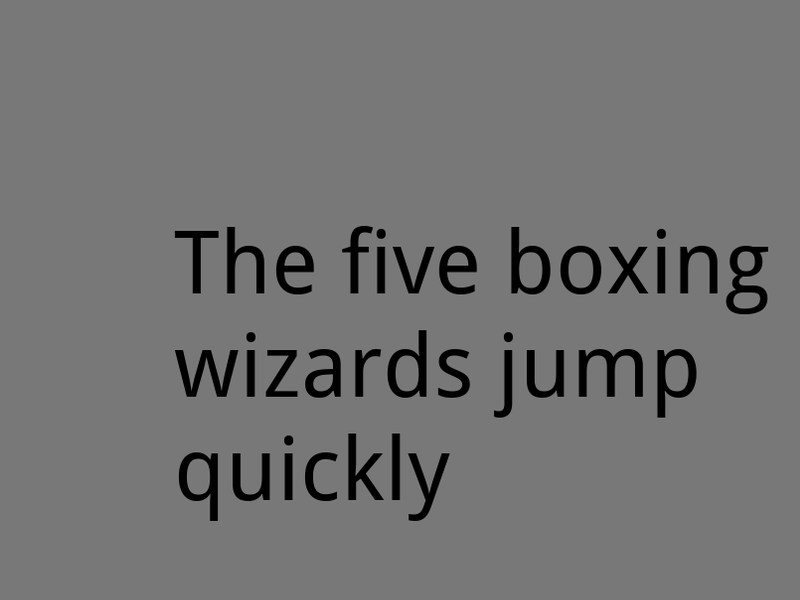

In [1306]:
t.inverse = not t.inverse
t.update('The five boxing wizards jump quickly')
t.image


In [1307]:
class xTextBlock(Block):
    """Constructor for TextBlock Class
    
    Child class of Block
    
    Individual image block used in assembling composite epdlib.Screen images 
    when writing to a WaveShare ePaper display.
    
    TextBlock objects are aware of their dimensions, absolute coordinates, and 
    contain an 1 bit PIL.Image object of the specified area.
    
    TextBlock objects format strings into multi-line text using wordwrap to 
    fit the maximum number of characters on each line given a particular font.
    
    TextBlock objects will calculate the maximum number of characters that will
    reasonably fit per line based on the font face, font size, area provided and
    the character distribution for a supported language. 
    
    TTF fonts (excluding monotype faces) render each character at a different width.
    The letter i takes less space than the letter W on a line. Each language 
    inherently has a different character distribution. In English, the lower-case
    `e` appears most frequently; Portugese and Turkish use `a` most frequently. 
    This difference in distrubution is subtle, but the aim of this module is to 
    provide the *maximum* number of characters per line.
    
    TextBlock objects use the letter distribution from a selected language (default
    is english) to calculate a random string and then size that string to fit the 
    area. 
    
    Supported languages can be found in the constants.py file.
    
    Format options include scaling, inverting and horizontal/vertical centering and
    random placement of the text within the area.
    
    Overrides:
        image (:obj:`PIL.Image` or str): PIL image object or string path to image file
        upate (method): update contents of ImageBlock"""        
    def __init__(self, font, area, *args, text='NONE', font_size=0, max_lines=1, maxchar=None, 
                 chardist=None, **kwargs):
        """Intializes TextBlock object
        
        Args:
            font (str): path to TTF font to use for rendering text
            text (str): string to render
            font_size (int): size of font in points
            max_lines (int): maximum number of lines of text to use 
            maxchar (int, optional): maximum number of characters to render
                per line. If this is not specified, it will be calculated
                using the fontface and a typical character distribution for 
                a given language (see chardist below)
            chardist (str, optional): string matching one of the character 
                distributions in constants.py (default USA_CHARDIST)
            """        
        super().__init__(area, *args, **kwargs)
        self.area = area
        
        logging.info('TextBlock created')
#         if chardist:
#             self._chardist = chardist
#         else:
#             self._chardist = constants.USA_CHARDIST
        self.chardist = chardist
    
        self.maxchar = maxchar
        self.font_size = font_size
        self.font = font
            
        self.max_lines = max_lines
        
        self.text = text
        
    @property
    def chardist(self):
        return self._chardist
    
    @chardist.setter
    def chardist(self, chardist):
        if not chardist:
            self._chardist = constants.USA_CHARDIST
        else:
            self._chardist = getattr(constants, chardist)
 
    @property
    def font_size(self):
        """:obj:int: Size of font in points"""        
        return self._font_size
    
    @font_size.setter
    @strict_enforce(int)
    def font_size(self, font_size):
        if font_size > 0:
            self._font_size = font_size
        else:
#             raise ValueError(f'font_size must be a positive int: {font_size}')
            self._font_size = int(self.area[0]/40)
            logging.debug(f'bad/no font size provided; setting font_size to usable size for given area: {self.font_size}')
            
        
    @property
    def font(self):
        """:obj:ImageFont.truetype: Path to TTF font file
        
        If the fontface is changed after initialization, it is recommended to
        recalculate the 
        
        Args:
            font(:obj:`pathlib.Path` or :obj:str)"""
        return self._font
    
    @font.setter
    @strict_enforce((Path, str))
    def font(self, font):
            
        if font:
            old_font = None
            logging.debug(f'setting old_font = {old_font}')
            if hasattr(self, '_font'):
                old_font = self.font
                logging.debug(f'old_font now = {old_font}')
            
            self._font = ImageFont.truetype(str(Path(font).resolve()), size=self.font_size)
            # trigger a calculation of maxchar if not already set
            if not self.maxchar or (self.font != old_font):
                self.maxchar = self._calc_maxchar()
                            
    @property
    def max_lines(self):
        """:obj:int maximum number of lines to use when word-wrapping"""
        return self._max_lines
    
    @max_lines.setter
    @strict_enforce(int)
    def max_lines(self, max_lines):
        self._max_lines = max_lines
        
    @property
    def maxchar(self):
        """:obj:int maximum number of characters on one line"""
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self._maxchar = maxchar
        else: 
            logging.debug('no maxchar set')
            self._maxchar = None

    @property
    def text(self):
        """:obj:str text string to format"""
        return self._text
    
    @text.setter
    @permissive_enforce(str)
    def text(self, text):
        self._text = text
        self.text_formatted = self._text_formatter()
        self.image = self._text2image()

    def _calc_maxchar(self):
        """calculate the maximum number of characters that can fit within the specified area
          using the current font, specified character distribution (`chardist`) 
          and x-dimension of the `area`
          
        Returns:
            :obj:int: characters per line"""
        if not self.font:
            raise AttributeError('no font is set - cannot calculate maximum characters per line')
        logging.debug(f'calculating maximum characters for font {self.font.getname()}')
        
        # holder for strings
        s = ''
        # max number of characters to sample from the character distribution
        n = 1000
        # create a random string of characters containing the letter distribution
        for char in self.chardist:
            s = s+(char*int(self.chardist[char]*n))
        s_length = self.font.getsize(s)[0] # string length in Pixles
        # find average width of each character
        avg_width = s_length/len(s)
        maxchar = round(self.area[0]/avg_width)
        self._maxchar = maxchar
        logging.debug(f'maximum characters per line: {maxchar}')
        
        return maxchar
 
            
    
    def _update_maxchar(self):
        """force an update of maxchar property"""
        self.max_char = False
    
    def _text_formatter(self):
        """format text using word-wrap strategies. 
        
        Formatting is based on number of lines, area size and maximum characters per line
        
        Args:
            text (str): raw text
            maxchar (int): maximum number of characters on each line
            max_lines (int): maximum number of lines
            
        Returns:
            :obj:`list` of :obj:`str`"""        
        logging.debug(f'formatting string: {self.text}')
        wrapper = textwrap.TextWrapper(width=self.maxchar, max_lines=self.max_lines, placeholder='…')
        formatted = wrapper.wrap(self.text)
        logging.debug(f'formatted list:\n {formatted}')
        return(formatted)       
    
    def _text2image(self):
        """Converts text to grayscale image using
        
        Sets:
            dimension (:obj:`tuple` of :obj:`int`): dimensions in pixles of image
        
        Returns:
            :obj:`PIL.Image`: image of formatted text"""
        logging.debug(f'creating blank image area: {self.area} with inverse: {self.inverse}')
        
        # create image for holding text
        text_image = Image.new('1', self.area, self.bkground)
        # get a drawing context
        draw = ImageDraw.Draw(text_image)
        
        # create an image to paste the text_image into
        image = Image.new('1', self.area, self.bkground)
        
        # set the dimensions for the text portion of the block
        y_total = 0
        x_max = 0
        for line in self.text_formatted:
            x, y = self.font.getsize(line)
            logging.debug(f'line size: {x}, {y}')
            y_total += y # accumulate height
            if x > x_max:
                x_max = x # find the longest line
                logging.debug(f'max x dim so far: {x_max}')
                
        # dimensions of text portion for formatting later
        self.dimensions = (x_max, y_total)
        logging.debug(f'dimensions of text portion of image: {self.dimensions}')     
        
        # layout the text with hcentering
        y_total = 0
        for line in self.text_formatted:
            x_pos = 0
            x, y = self.font.getsize(line)
            if self.hcenter:
                logging.debug(f'hcenter line: {line}')
                x_pos = round(self.dimensions[0]/2-x/2)
            logging.debug(f'drawing text at {x_pos}, {y_total}')
            logging.debug(f'with dimensions: {x}, {y}')
            draw.text((x_pos, y_total), line, font=self.font, fill=self.fill)
            y_total += y
            
        # produce the final image
        # Start in upper left corner
        x_pos = 0
        y_pos = 0

        if self.rand:
            logging.debug('randomly positioning text within area')
            x_range = self.area[0] - self.dimensions[0]
            y_range = self.area[1] - self.dimensions[1]
            

            x_pos = randrange(x_range)

            y_pos = randrange(y_range)

        else: # random and h/v center are mutually exclusive            
            if self.hcenter:
                x_pos = round(self.area[0]/2 - self.dimensions[0]/2)
            if self.vcenter:
                y_pos = round(self.area[1]/2 - self.dimensions[1]/2)
    
    
        logging.debug(f'pasting text portion at coordinates: {x_pos}, {y_pos}')
        image.paste(text_image, (x_pos, y_pos))
            
                
        return image
    
    def update(self, update=None):
        """Update image data including coordinates (overrides base class)
        
        Args:
            update (str): text to format and use
            
        Returns:
            :obj:bool - true for successful update"""
        if update:
            try:
                self.text = update
            except Exception as e:
                logging.error(f'failed to update: {e}')
                return False
            return True
        
    def print_chardist(self, chardist=None):
        """Print supported character distributions
        
            call with no arguments to see available distributions
            
            call with name of character distrubtion to see fractional distribution
        
        Args:
            chardist(:obj:str): string representing listed character distribution """
        if not chardist:
            print('available character distributions:')
            print ([ f'{i}' for i in dir(constants) if not i.startswith("__")])
        else:
            print(f'Character Distribution for {chardist}:')
            char_dict = getattr(constants, chardist)
            
            for i in char_dict:
                print(f'{i}:     {char_dict[i]:.5f}')
                


In [1352]:
class ImageBlock(Block):
    def __init__(self, area, *args, image=None, **kwargs):
        super().__init__(area, *args, **kwargs)
        
        self.image = image
        
    @property
    def image(self):
        return self._image
    
    @image.setter
    def image(self, image):
        image_area = Image.new(self.mode, self.area, self.bkground)
    
        if not image:
            logging.debug(f'no image set; setting to blank image with area: {self.area}')
            self._image = image_area

        if image:
            
            ## FIXME -- probably need to determine if it's a landscape/portrait image
            thumbnail_min = max(self.area)-self.padding*2
            logging.debug(f'thumbnail min: {thumbnail_min}')

            if isinstance(image, (str, Path)):
                try:
                    im = Image.open(image)

                except (PermissionError, FileNotFoundError, OSError) as e:
                    raise BlockError(f'Could not open file "{image}": {e}')
            elif isinstance(image, Image.Image):
                im = image
                
            if max(im.size) > thumbnail_min:
                im.thumbnail((thumbnail_min, thumbnail_min))
            
            if self.inverse:
                im = ImageOps.invert(im)
   
            paste_x = self.padding
            paste_y = self.padding

            if self.hcenter:
                paste_x = int((self.area[0] - im.width)/2)

            if self.vcenter:
                paste_y = int((self.area[1] - im.height)/2) 

            if self.rand:
                if self.hcenter:
                    logging.warning('`rand` overrides hcenter')
                if self.vcenter:
                    logging.warning('`rand` overrides vcenter')
                x_range = int(self.area[0] - im.width - self.padding)
                y_range = int(self.area[1] - im.height - self.padding)
                logging.debug(f'x_range: {x_range}, y_range: {y_range}')



                # choose random placement
                try:
                    paste_x = randrange(self.padding, x_range-self.padding, 1)
                except ValueError as e:
                    logging.info('x image dimension is too large for random placement')
                
                try:
                    paste_y = randrange(self.padding, y_range-self.padding, 1)  
                except ValueError as e:
                    logging.info('y image dimension is too large for random placement')

            image_area.paste(im, (paste_x, paste_y))
            
            self._image = image_area
    
    def update(self, update=None):
        """Update image data including coordinates (overrides base class)
        
        Args:
            update(PIL or Path): image to use in update
            
        Returns:
            :obj:bool on success"""        
        if update:
            try:
                self.image = update
            except Exception as e:
                logging.error(f'failed to update due to error: {e}')
                return False
            return True
        else:
            logging.warn('update called with no arguments, no action taken')
            return False        

DEBUG:root:fill: 0, bkground: 200
DEBUG:root:creating Block
DEBUG:root:thumbnail min: 790


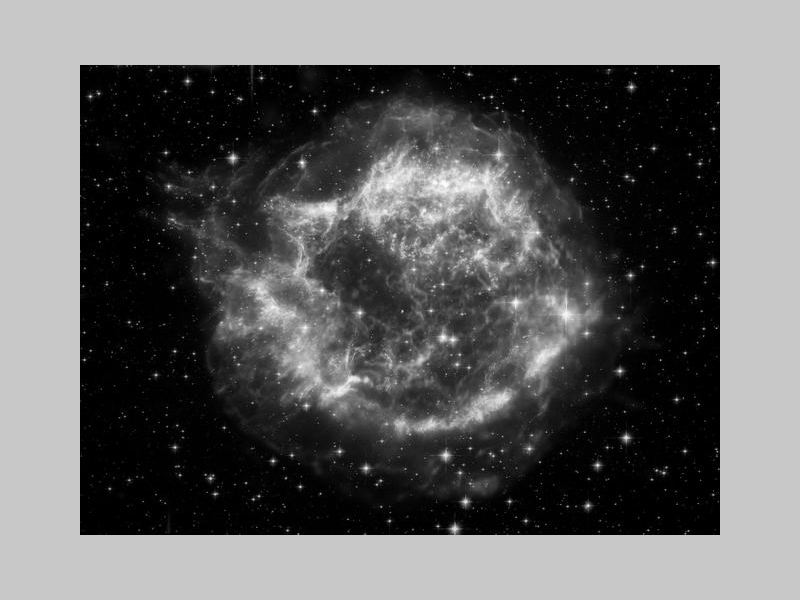

In [1358]:
i = ImageBlock(area=(800, 600), image='../PIA03519_small.jpg', mode='L', 
               hcenter=True, vcenter=True, padding=5, rand=False, inverse=False, bkground=200)

# i.update('../PIA03519_small.jpg')

i.image

DEBUG:root:fill: 200, bkground: 0
DEBUG:root:thumbnail min: 790


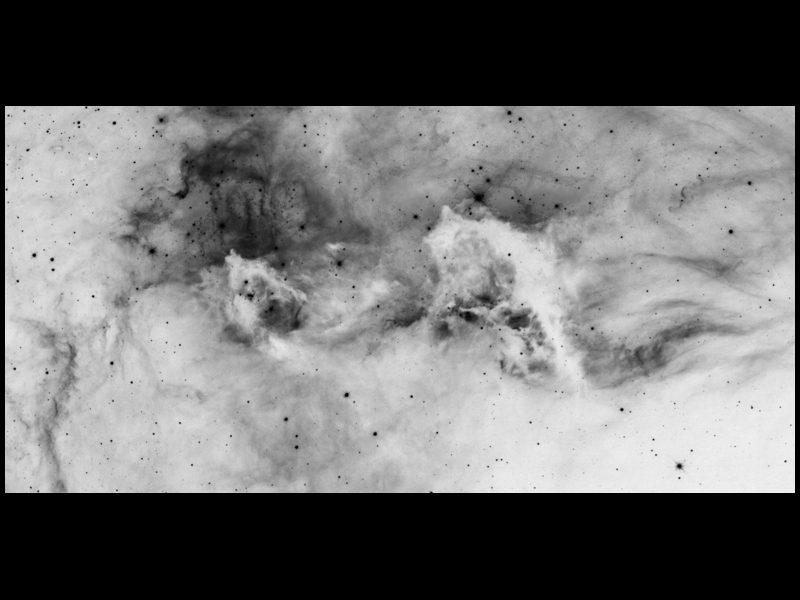

In [1366]:
i.inverse = not i.inverse
i.vcenter = not i.vcenter
i.update('../hubble.jpg')
i.image

In [1227]:
class xImageBlock(Block):
    
    def __init__(self, area, *args, image=None, **kwargs):
        super().__init__(area, *args, **kwargs)
        
        self.area = area
        logging.info('Image Block Created')
        logging.debug(f'image={image}')
        self.image = image

    @property
    def image(self):
        return self._image

    @image.setter
    def image(self, image):
        image_area = Image.new('L', self.area, self.bkground)
        logging.debug(f'block area: {self.area}')
        if not image:
            logging.debug(f'no image provided, setting to blank image: {self.area}')
            self._image = image_area
            return

        # use the smallest dimension of the area use for scaling thumbnails
        thumbnail_min = min(self.area)-self.padding*2
        logging.debug(f'max dimension of thumbnail: {thumbnail_min}')

        # handle image files
        if isinstance(image, (str, Path)):
            logging.debug(f'using image file: {image}')
            try:
                im = Image.open(image)
                logging.debug(f'creating thumbnail of image to fit in min dimension : {thumbnail_min}')
                im.thumbnail((thumbnail_min, thumbnail_min))
            except (PermissionError, FileNotFoundError, OSError) as e:
                logging.warning(f'could not open image file {image}')
                logging.warning(f'error: {e}')
                logging.warning(f'using empty image')
                self._image = image_area

        elif isinstance(image, Image.Image):
            logging.debug(f'using PIL image')
            im = image
            if max(im.size) > thumbnail_min:
                logging.debug(f'creating thumbnail of image to fit in min dimension : {thumbnail_min}')
                im.thumbnail((thumbnail_min, thumbnail_min))

        self.dimensions = im.size
        logging.debug(f'final dimensions of resized image: {self.dimensions}')

        x_pos = self.padding
        y_pos = self.padding
        
        logging.debug(f'starting with x: {x_pos}, y: {y_pos}')

        if self._rand:
            # pick random coordinates for the image within the area
            logging.debug('using random coordinates for image within area')
            x_range = self.area[0] - self.dimensions[0] - self.padding*2
            y_range = self.area[1] - self.dimensiosn[1] - self.padding*2
            x_pos = randrange(x_range)+padding
            y_pos = randrange(y_range)+padding

        # h/v center is mutually exclusive to random
        else:
            if self.hcenter:
                logging.debug('h-center image')
                x_pos = round((self.area[0]-self.dimensions[0])/2)
            if self.vcenter:
                logging.debug('v-center image')
                y_pos = round((self.area[1]-self.dimensions[1])/2)
        if self.inverse:
            im = ImageOps.invert(im)

        logging.debug(f'pasting image into area at {x_pos}, {y_pos}')
        image_area.paste(im, [x_pos, y_pos])

        self._image = image_area
        
    def update(self, update=None):
        """Update image data including coordinates (overrides base class)
        
        Args:
            update (str): text to format and use
            
        Returns:
            :obj:bool on success"""        
        if update:
            try:
                self.image = update
            except Exception as e:
                logging.error(f'failed to update due to error: {e}')
                return False
            return True
        else:
            logging.warn('update called with no arguments, no action taken')
            return False

In [1214]:
i = ImageBlock(area=(800, 600))

i.update('../PIA03519_small.jpg')

i.image

DEBUG:root:fill: 255, bkground: 0
DEBUG:root:creating Block
INFO:root:Image Block Created
DEBUG:root:image=None
DEBUG:root:block area: (800, 600)
DEBUG:root:no image provided, setting to blank image: (800, 600)


In [ ]:
def dir2dict(obj):
    d = {}
    for i in dir(obj):
        d[i] = id(i)
    return d

In [ ]:
def compare_obj(a, b):
    d = []
    for key in a: 
        if key in b:
            if a[key] == b[key]:
                d.append((key, a[key]))
                
    return d

In [ ]:
# logger = logging.getLogger(__name__)
# logger.root.setLevel('DEBUG')